# Earthquake risk in Greece

This project is quite different from a software development task.

Don't hesitate to contact us, if you have any doubts on what is asked or if you encounter error will using the notebook.

In [1]:
%reload_ext autoreload
%autoreload 2

## Constraints

+ 🚨 Only cells with the comment `# NOTE: Fill me!` should be filled
+ 🚨 Notebook should be saved and commited **with** outputs for the submission


+ ⚠️ The solution only requires packages listed in the `requirements/requirements.txt`
+ ⚠️ Unit tests should be favored when asked to write tests 
+ ⚠️ Tests must automatically be detected running `pytest`
+ ⚠️ Requested method signature should be inferred from this notebook


## Note

+ The `assert` statements in the notebook are here to guide the project.
However, successful `assert` statements does not guaranty that your code is correct.

## Setup

In a Python >= 3.8 virtual env, run:

In [2]:
! pip install -r ../requirements/requirements.txt
! pip install --no-deps -e ..

Obtaining file:///home/bvrabete/dev/interviews/software-engineer-technical-test
  Attempting uninstall: earthquakes
    Found existing installation: earthquakes 1.0.dev0
    Uninstalling earthquakes-1.0.dev0:
      Successfully uninstalled earthquakes-1.0.dev0
  Running setup.py develop for earthquakes


## Tests

In [3]:
! cd .. && pytest ; cd -

============================= test session starts ==============================
platform linux -- Python 3.9.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /home/bvrabete/dev/interviews/software-engineer-technical-test
collected 4 items                                                              

tests/src/earthquakes/test_usgs_api.py ....                              [100%]

============================== 4 passed in 0.31s ===============================
/home/bvrabete/dev/interviews/software-engineer-technical-test/notebook


---

# Context

A client asks for an insurance of their asset, located at `(35.025, 25.763)` in Greece.

The client wishes to receive a payout under the following conditions:

+ earthquake of magnitude `4.5` or higher within `10km`: full payout
+ earthquake of magnitude `5.5` or higher within `50km`: `75%` payout
+ earthquake of magnitude `6.5` or higher within `200km`: `50%` payout

In the event of aftershocks, a payout can only occur once a year using the maximal value.

## Example

If in the same year:

* an earthquake of magnitude `6.8` occurs within `200km`
* **and** an aftershock of magnitude `5.8` occurs within `50km`

the client receives a `75%` payout, and not a `125%` payout.

In [4]:
! which python

/home/bvrabete/anaconda3/envs/py39/bin/python


In [5]:
import numpy as np
import pandas as pd
from datetime import datetime

from earthquakes.tools import (
    DISTANCE_COLUMN,
    LATITUDE_COLUMN,
    LONGITUDE_COLUMN,
) 

# Earthquake data

The US Geological Service (USGS) provides CSV data through their [API](https://earthquake.usgs.gov/fdsnws/event/1/).

Use it to retrieve earthquake information.

In the module `earthquakes.usgs_api`:
+ Implement the function `get_earthquake_data`,
+ The function will retrieve the earthquake data of the area of interest for the past 200 years,
+ The implementation must use the `urllib` python package,
+ The API request url must be build in a dedicated function `build_api_url`,
+ Tests should be provided for `build_api_url`.

Note: Earthquakes after the 21-10-2021 should not be considered.

In [6]:
from earthquakes.usgs_api import get_earthquake_data

In [7]:
# NOTE: Fill me!

latitude = 35.025
longitude = 25.763
radius = 200.0
minimum_magnitude = 4.5

In [8]:
from datetime import datetime

# NOTE: This request may take significant time (>10s)
earthquake_data = get_earthquake_data(
    latitude=latitude,
    longitude=longitude,
    radius=radius,
    minimum_magnitude=minimum_magnitude,
    end_date=datetime(year=2021, month=10, day=21)
)

In [9]:
assert isinstance(earthquake_data, pd.DataFrame)
assert len(earthquake_data) == 734

## Warning

The next test may fail because USGS regularly updates their earthquake database.

The dataframe obtained should over be similar to that presented bellow.

Please contact us if there is an error.

In [10]:
expected_earthquake_data = pd.DataFrame([
        ["2021-10-12T09:24:05.099Z", 35.1691, 26.2152, 20.0, 6.4, "mww", np.nan, 19.0, 0.860, 0.46,"us", "us6000ftxu", "2021-12-18T19:58:57.040Z", "4 km SW of Palekastro, Greece", "earthquake", 6.1, 1.8, 0.048, 42.0, "reviewed", "us", "us"],
        ["2021-10-03T14:31:27.622Z", 35.1442, 25.2375, 10.0, 4.6, "mb", np.nan, 119.0, 0.318, 0.64, "us", "us6000fsp1", "2021-12-10T21:14:19.040Z", "2 km W of Arkalochóri, Greece", "earthquake", 5.0, 1.9, 0.165, 13.0, "reviewed", "us", "us"],
        ["2021-09-29T11:54:48.885Z", 35.0268, 25.1561, 10.0, 4.6, "mb", np.nan, 69.0, 0.339, 0.83, "us", "us6000fq3y", "2021-12-04T14:27:58.040Z", "2 km N of Pýrgos, Greece", "earthquake", 5.1, 1.3, 0.068, 64.0, "reviewed", "us", "us"],
        ["2021-09-28T15:13:16.867Z", 35.2054, 25.2791, 10.0, 4.7, "mb", np.nan, 58.0, 0.329, 0.70, "us", "us7000ff84", "2021-12-04T14:30:09.040Z", "1 km N of Thrapsanón, Greece", "earthquake", 6.9, 1.8, 0.067, 73.0, "reviewed", "us", "us"],
        ["2021-09-28T04:48:08.650Z", 35.0817, 25.2018, 10.0, 5.3, "mww", np.nan, 43.0, 0.328, 0.94, "us", "us7000ff36", "2021-12-04T14:30:04.040Z", "9 km SW of Arkalochóri, Greece", "earthquake", 4.5, 1.7, 0.046, 45.0, "reviewed", "us", "us"],
    ],
    columns=['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource']
)

In [11]:
earthquake_data_sample = earthquake_data[
    earthquake_data["time"].isin(expected_earthquake_data["time"])
]

# NOTE: [BV] commented out the next statement as the `updated` column has some updated data

# pd.testing.assert_frame_equal(earthquake_data_sample, expected_earthquake_data)

# Distance

We wish to compute the the historical payouts (i.e. the payouts that would have occurred for the past 200 years).

To compute the historical payouts, we need to know the distance between each earthquake and our client's asset.

The distance between two points on a sphere is the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). In the module `eathquakes.tools`:
- Implement and test the function `get_haversine_distance`,
- Use `earthquakes.tools.EARTH_RADIUS` (6378km) as an approximation of the radius of Earth.

In [12]:
from earthquakes.tools import get_haversine_distance

distances = get_haversine_distance(earthquake_data[LATITUDE_COLUMN], earthquake_data[LONGITUDE_COLUMN], latitude, longitude)

earthquake_data[DISTANCE_COLUMN] = distances

## Historical payouts and burning costs

### Payout

The historical payouts are a map `year -> payout in %`.

eg: `1950: 50` for a payout of `50%` in 1950.

Payouts are NOT given per event, but per year.

This map can take the form of a python `dict` or of a pandas `Series`. 

### Burning cost

The `burning cost` is the average of payouts over a time range.

In this project, the burning cost should be expressed in `%`. 

### Payout structure

The payout structure is:

| Radius | Magnitude | Payout |
|--------|-----------|--------|
| 10km   | 4.5       | 100 %  |
| 50km   | 5.5       |  75 %  |
| 200km  | 6.5       |  50 %  |

Even though multiple events can happen in a given year, clients can only receive one payout.

In the module `earthquakes.tools`:
+ Implement the functions `compute_payouts` and `compute_burning_cost`,
+ Tests for these functions are not required.

### Example

A payout `{1950: 50, 1992: 75}` means that we would have paid our client
+ in 1950, for `50%` of the insured amount (called 'limit')
+ in 1992, for `75%` of the limit

The burning cost over the `1922-2021` period would be `1.25%`.

The burning cost over the `1972-2021` period would be `1.5%`.

In [13]:
from earthquakes.tools import compute_payouts, compute_burning_cost

In [14]:
payout_structure = [{"radius": 10.0, "magnitude": 4.5, "payout": 100.0},
                    {"radius": 50.0, "magnitude": 5.5, "payout": 75.0},
                    {"radius": 200.0, "magnitude": 6.5, "payout": 50.0}]

In [15]:
payouts = compute_payouts(earthquake_data, payout_structure)

In [16]:
# Depending on the return type of compute_payouts, the following line needs to be adjusted.
# - pd.Series:
payout_values = np.array(payouts.values)
# - dict:
# payout_values = np.array(list(payouts.values()))
assert np.max(payout_values) > 1
assert np.max(payout_values) <= 100

In [17]:
burning_cost = compute_burning_cost(payouts, start_year=1952, end_year=2021)

In [18]:
np.testing.assert_allclose(burning_cost, 10.71, atol=1e-2)

In [19]:
import matplotlib.pyplot as plt

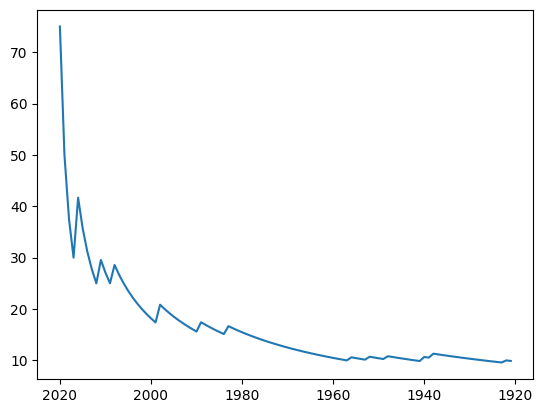

In [20]:
years = range(1921, 2021)
plt.plot(
    years, 
    [
        compute_burning_cost(payouts, start_year=start_year, end_year=2021) 
        for start_year in years
    ]
)
plt.gca().invert_xaxis()

# Large asset portfolio - async requests

Our client also whishes to cover a large amount of properties all over Europe.

In order to speed-up the requests to the USGS API, in the module `earthquakes.usgs_api`:
- Implement the `async` function `get_earthquake_data_for_multiple_locations`,
- The implementation should use the `asyncio` and `aiohttp` libraries,
- The solution should re-use some of the functions already written,
- Tests are not required for any of the functions.

Note: it is possible that the notebook autoreload feature doesn't work for `async` functions - a kernel restart may be necessary after each modifications.

In [21]:
import numpy as np
import pandas as pd
from datetime import datetime

from earthquakes.tools import (
    LATITUDE_COLUMN,
    LONGITUDE_COLUMN,
)

In [22]:
number_of_assets = 10
# NOTE: limiting to number of assets so that the query doesn't take too long.

In [23]:
random_state = np.random.RandomState(0)

random_values = random_state.random(2*number_of_assets)

latitudes = random_values[::2] * 20 + 35.0
longitudes = random_values[1::2] * 25 + 3.0

In [24]:
from earthquakes.usgs_api import get_earthquake_data_for_multiple_locations

In [25]:
# NOTE: Fill me!
assets = pd.DataFrame()
assets[LATITUDE_COLUMN] = latitudes 
assets[LONGITUDE_COLUMN] = longitudes

In [26]:
# NOTE: This request may take significant time (>10s)
earthquake_data = await get_earthquake_data_for_multiple_locations(  # type: ignore
    assets, 
    radius=200, 
    minimum_magnitude=4.5, 
    end_date=datetime(year=2021, month=10, day=21)
)

In [27]:
assert isinstance(earthquake_data, pd.DataFrame)
assert len(earthquake_data) == 1151

AssertionError: 